In [145]:
import pandas as pd
train_df = pd.read_csv('data/train_dataset.csv', encoding='utf-8-sig')
test_df = pd.read_csv('data/test_dataset.csv', encoding='utf-8-sig')

In [147]:
import re

def clean_text(text):
    text = re.sub(r"[^가-힣a-zA-Z0-9\s]", "", text)  # 한글, 영어, 숫자, 공백만 유지
    text = re.sub(r"\s+", " ", text).strip()  # 중복 공백 제거
    return text

train_df["text"] = train_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)


In [149]:
train_df.head()

,text,emotion,situation
0,일은 왜 해도 해도 끝이 없을까 화가 난다 그냥 내가 해결하는 게 나아 남들한테 부...,E18,S06
1,이번 달에 또 급여가 깎였어 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나 최...,E18,S06
2,회사에 신입이 들어왔는데 말투가 거슬려 그런 애를 매일 봐야 한다고 생각하니까 스트...,E18,S06
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜 일도 많은 데 정말 분하고 섭...,E18,S06
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나 상사인 나에게 먼...,E18,S06


In [151]:
from konlpy.tag import Okt
import random
import gensim
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 🔹 Step 1: 형태소 분석기 초기화
print("🔄 형태소 분석기 (Okt) 초기화 중...")
okt = Okt()

# 🔹 Step 2: FastText 모델 로드
print("⏳ FastText 모델 로딩 중...")
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format(
    "C:/fasttext/cc.ko.300.vec.gz",
    binary=False,
    encoding="latin1"  # ✅ 인코딩을 UTF-8에서 latin1로 변경
)
print("✅ FastText 모델 로드 완료!")


🔄 형태소 분석기 (Okt) 초기화 중...
⏳ FastText 모델 로딩 중...
✅ FastText 모델 로드 완료!


📊 감정 데이터 불균형 분석 중...
🔍 부족한 감정 클래스 개수: 20
emotion
E36    860
E50    859
E54    859
E15    845
E35    842
E46    840
E25    838
E57    833
E26    828
E14    803
E60    660
E64    655
E67    639
E68    634
E61    631
E62    609
E63    597
E69    570
E66    568
E65    563
Name: count, dtype: int64
🛠 부족한 감정 데이터 증강 중...


📌 Synonym Replacement 진행 중: 100%|███████████████████████████████████████████| 14533/14533 [01:13<00:00, 197.50it/s]


✅ 데이터 증강 완료!
🔗 원본 데이터와 증강 데이터를 병합 중...
✅ 최종 데이터셋 생성 완료! 총 66161 개 샘플
📊 데이터 증강 전후 분포 시각화...


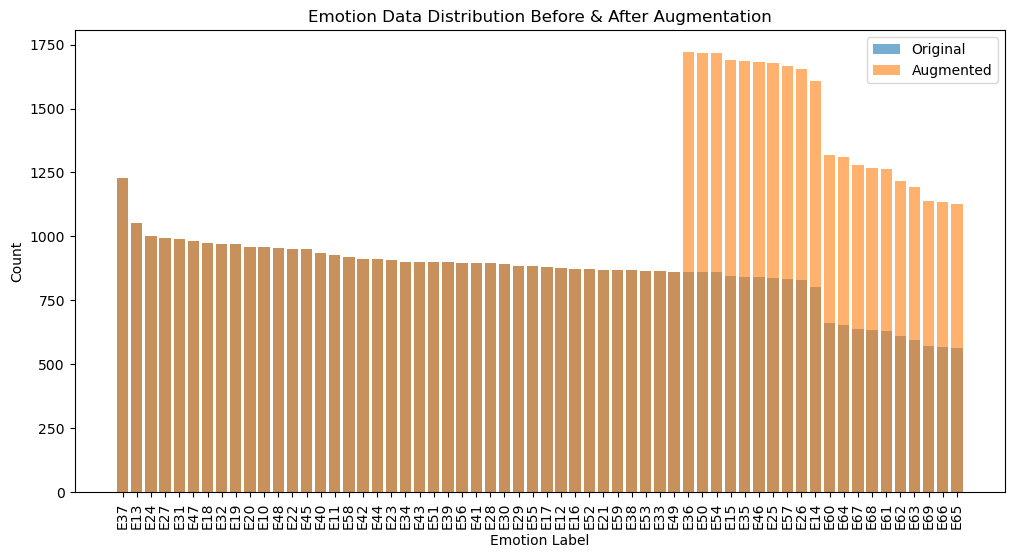

🎉 모든 작업 완료!


In [152]:


# ✅ 동의어 추출 함수 (FastText 활용)
def get_synonyms(word, topn=3):
    try:
        synonyms = fasttext_model.most_similar(word, topn=topn)
        return [syn[0] for syn in synonyms]
    except KeyError:
        return [word]  # 없는 단어는 원본 유지

# ✅ Synonym Replacement (Okt 활용)
def synonym_replacement(sentence, n=1):
    words = okt.morphs(sentence)  # 형태소 분석
    new_sentence = sentence
    count = 0
    for word in words:
        synonyms = get_synonyms(word)
        if len(synonyms) > 1:
            new_sentence = new_sentence.replace(word, random.choice(synonyms), 1)
            count += 1
        if count >= n:
            break
    return new_sentence


# 🔹 Step 4: 감정 데이터 불균형 확인
print("📊 감정 데이터 불균형 분석 중...")
emotion_counts = train_df['emotion'].value_counts()
mean_count = emotion_counts.mean()
underrepresented_emotions = emotion_counts[emotion_counts < mean_count]

print(f"🔍 부족한 감정 클래스 개수: {len(underrepresented_emotions)}")
print(underrepresented_emotions)

# 🔹 Step 5: 부족한 감정 데이터 필터링 후 증강 적용
print("🛠 부족한 감정 데이터 증강 중...")
underrepresented_df = train_df[train_df['emotion'].isin(underrepresented_emotions.index)]

augmented_texts = []
augmented_labels = []
augmented_situations = []

for _, row in tqdm(underrepresented_df.iterrows(), total=len(underrepresented_df), desc="📌 Synonym Replacement 진행 중"):
    new_text = synonym_replacement(row['text'], n=2)  # 최대 2개 단어 치환
    augmented_texts.append(new_text)
    augmented_labels.append(row['emotion'])
    augmented_situations.append(row['situation'])

print("✅ 데이터 증강 완료!")


# 🔹 Step 6: 증강된 데이터프레임 생성
augmented_df = pd.DataFrame({'text': augmented_texts, 'emotion': augmented_labels, 'situation': augmented_situations})

# 🔹 Step 7: 원본 데이터와 병합하여 최종 데이터셋 생성
print("🔗 원본 데이터와 증강 데이터를 병합 중...")
final_df = pd.concat([train_df, augmented_df])
print(f"✅ 최종 데이터셋 생성 완료! 총 {len(final_df)} 개 샘플")


# 🔹 Step 8: 시각화 - 감정 데이터 분포 비교
print("📊 데이터 증강 전후 분포 시각화...")
plt.figure(figsize=(12, 6))
plt.bar(emotion_counts.index, emotion_counts.values, label="Original", alpha=0.6)
plt.bar(final_df['emotion'].value_counts().index, final_df['emotion'].value_counts().values, label="Augmented", alpha=0.6)
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.title('Emotion Data Distribution Before & After Augmentation')
plt.xticks(rotation=90)
plt.legend()
plt.show()

print("🎉 모든 작업 완료!")


In [153]:
final_df.to_csv('data/250314_augmented_train_df.csv', encoding='utf-8-sig')

In [ ]:
tmp_df = pd.read_csv('data/250314_augmented_train_df.csv')

In [127]:
tmp_df = pd.read_csv('data/250314_augmented_train_df.csv', encoding='utf-8-sig')  # 또는 'latin1'


In [137]:
tmp_df.head(50)

,Unnamed: 0,text,emotion,situation
0,0,일은 왜 해도 해도 끝이 없을까? 화가 난다. 그냥 내가 해결하는 게 나아. 남들한...,E18,S06
1,1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,E18,S06
2,2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,E18,S06
3,3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,E18,S06
4,4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나. 상사인 나에게 ...,E18,S06
5,5,직장에 다니고 있지만 시간만 버리는 거 같아. 진지하게 진로에 대한 고민이 생겨. ...,E18,S06
6,6,성인인데도 진로를 아직도 못 정했다고 부모님이 노여워하셔. 나도 섭섭해. 부모님께 ...,E18,S06
7,7,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고. 더 좋은 회사가 기다리고 있을...,E66,S06
8,8,졸업반이라서 취업을 생각해야 하는데 지금 너무 느긋해서 이래도 되나 싶어. 응. 느...,E37,S06
9,9,요즘 직장생활이 너무 편하고 좋은 것 같아! 우리 회사는 복지가 정말 좋아! 내가 ...,E66,S06
